# EasyEdit Example with **IKE**
> Tutorial author: Ting Lu(<luting1@shanghaitech.edu.cn>) and Bozhong Tian(<tbozhong@zju.edu.cn>)
> 
In this tutorial, we use `IKE` to edit `gpt2` ans `LlaMA` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3.9`.

# Model Editing
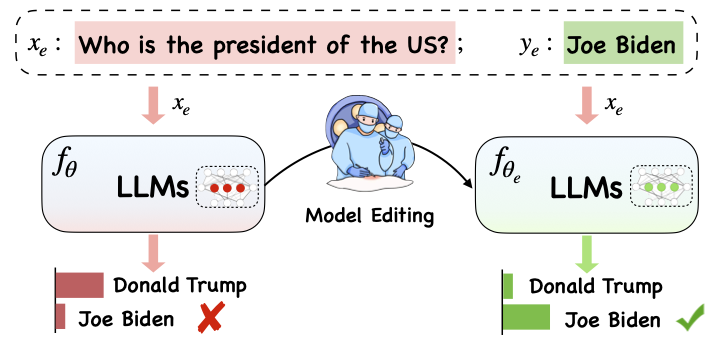

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
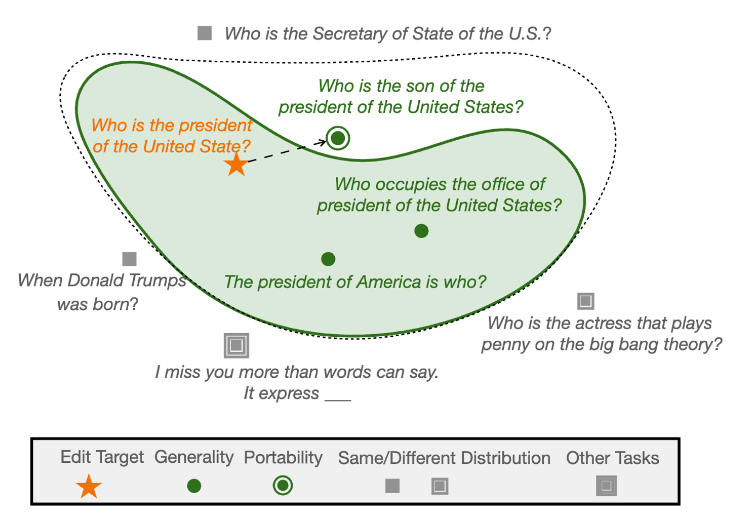

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **IKE**

Paper: [Can We Edit Factual Knowledge by In-Context Learning?](https://arxiv.org/abs/2305.12740)

**IKE** (In-context Knowledge Editing), is a way of editing factual knowledge in large language models **without modifying their parameters**, but by **providing different types of natural language demonstrations** as part of the input.  
It can achieve competitive knowledge editing performance **with less computation overhead and side effects**, as well as better scalability and interpretability.

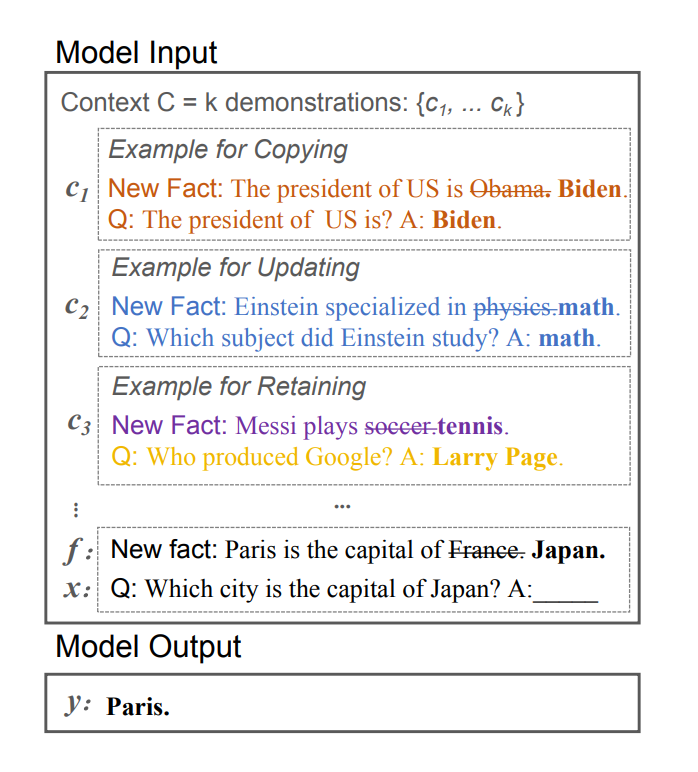

## Prepare the runtime environment

In [1]:
## Clone Repo
!git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!dir

C:\Users\Tecno\Downloads\EasyEdit


fatal: destination path 'EasyEdit' already exists and is not an empty directory.
C:\Users\Tecno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : F2CF-A969

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\Tecno\Downloads\EasyEdit

25.03.2025  10:21    <DIR>          .
25.03.2025  13:55    <DIR>          ..
25.03.2025  10:08               127 .gitignore
25.03.2025  10:08               191 colab_requirements.txt
25.03.2025  10:08    <DIR>          demo
25.03.2025  10:08             1я572 Dockerfile
25.03.2025  12:27    <DIR>          EasyEdit
25.03.2025  10:08    <DIR>          easyeditor
25.03.2025  10:08           126я545 edit.py
25.03.2025  10:08    <DIR>          examples
25.03.2025  10:08    <DIR>          figs
25.03.2025  10:08    <DIR>          hparams
25.03.2025  10:08             1я088 LICENSE
25.03.2025  10:08            26я737 multimodal_edit.py
25.03.2025  10:08            68я109 README.md
25.03.2025  10:08               503 requirements.txt
25.03.2025  10:08    <DIR>          tutorial-notebooks
25.03.2025  10:08         5я897я024 tutorial.pdf
               9 д ©«®ў      6я121я896 

In [2]:
# !apt-get install python3.9

In [3]:
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
# !sudo update-alternatives --config python3

In [4]:
# !apt-get install python3-pip
!py -m ensurepip --upgrade
!py -V:3.9 -m pip install -r requirements.txt
!py -V:3.9 -m pip install zhipuai==2.1.5.20250106
!py -V:3.9 -m pip install higher
!py -V:3.9 -m pip install omegaconf
!py -V:3.9 -m pip install opencv-python
!py -V:3.9 -m pip install einops
!py -V:3.9 -m pip install hydra-core
!py -V:3.9 -m pip install timm
!py -V:3.9 -m pip install iopath
!py -V:3.9 -m pip install fairscale
!py -V:3.9 -m pip install accelerate
!py -V:3.9 -m pip install peft

Looking in links: c:\Users\Tecno\AppData\Local\Temp\tmp6tzpl8b_
  Using cached sentence_transformers-3.2.1-py3-none-any.whl (255 kB)
  Using cached transformers-4.46.2-py3-none-any.whl (10.0 MB)
  Using cached openai-1.57.0-py3-none-any.whl (389 kB)
  Using cached peft-0.7.1-py3-none-any.whl (168 kB)
  Using cached av-14.2.0-cp39-cp39-win_amd64.whl (30.9 MB)
  Using cached qwen_vl_utils-0.0.10-py3-none-any.whl (6.7 kB)


ERROR: Could not find a version that satisfies the requirement zhipuai==2.1.5 (from versions: 1.0.4, 1.0.7, 2.0.1, 2.0.1.1, 2.0.1.20230426, 2.0.1.20240423, 2.0.1.20240423.1, 2.0.1.20240426, 2.0.1.20240427, 2.0.1.20240429, 2.1.0, 2.1.0.20240521, 2.1.1.20240620.1, 2.1.2, 2.1.3, 2.1.4, 2.1.4.20230731, 2.1.4.20230806, 2.1.4.20230809.1, 2.1.4.20230812, 2.1.4.20230814, 2.1.5.20230904, 2.1.5.20241203, 2.1.5.20241204, 2.1.5.20250106)
ERROR: No matching distribution found for zhipuai==2.1.5
You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
!py -V:3.9 -m pip list

Package                Version
---------------------- --------------
accelerate             1.5.2
aiohappyeyeballs       2.6.1
aiohttp                3.11.14
aiosignal              1.3.2
annotated-types        0.7.0
ansicon                1.89.0
antlr4-python3-runtime 4.8
anyio                  4.9.0
async-timeout          5.0.1
attrs                  25.3.0
blessed                1.20.0
cachetools             5.5.2
certifi                2025.1.31
charset-normalizer     3.4.1
click                  8.1.8
colorama               0.4.6
cycler                 0.12.1
datasets               1.18.3
dill                   0.3.9
easyeditor             0.0.1.dev0
einops                 0.4.0
exceptiongroup         1.2.2
fairscale              0.4.13
filelock               3.18.0
fonttools              4.56.0
frozenlist             1.5.0
fsspec                 2025.3.0
gpustat                1.1
h11                    0.14.0
higher                 0.2.1
httpcore               1.0.7
httpx        

You should consider upgrading via the 'C:\Users\Tecno\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Config Method Parameters


```python
# For IKE hparams:
alg_name: "IKE"
model_name: "gpt2" or "llama-7B"
sentence_model_name: "all-MiniLM-L6-v2"
device: 0
results_dir: "./results"

k: 32
```



In [7]:
!pip install matplotlib
!pip install sentence_transformers

## Import modules & Run

In [8]:
%cd ..

C:\Users\Tecno\Downloads


### For GPT Model

In [11]:
!pip list

Package                   Version        Editable project location


------------------------- -------------- --------------------------------------------
accelerate                1.5.2
aiohttp                   3.9.5
aiosignal                 1.3.1
alembic                   1.13.1
annotated-types           0.7.0
antlr4-python3-runtime    4.9.3
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
asyncio                   3.4.3
attrs                     23.2.0
av                        14.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
cachetools                5.5.2
certifi                   2024.2.2
cffi                      1.16.0
charset-normalizer        3.3.2
clarabel                  0.9.0
click                     8.1.8
colorama                  0.4.6
colorlog                  6.8.2
comm                      0.2.2
contourpy                 1.2.1
cvxpy 

In [15]:
### For GPT Model
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

In [29]:
hparams = IKEHyperParams.from_hparams('./hparams/IKE/gpt2-xl')
hparams.model_name = hparams.model_name.split('/')[-1]
print(hparams)
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    sequential_edit=True
)

print(metrics)

2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-26 02:39:02,848 - easyeditor.editors.editor - INFO - Instantiating model
03/26/2025 02:39:02 - INFO - easyeditor.editors.editor -   Instantiating model


IKEHyperParams(device=0, alg_name='IKE', model_name='gpt2-xl', sentence_model_name='./hugging_cache/all-MiniLM-L6-v2', k=16, results_dir='./results', use_icl_examples=True, model_parallel=False)


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

C:\Users\Tecno\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tecno\.cache\huggingface\hub\models--gpt2-xl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-03-26 02:43:01,970 - easyeditor.edit

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [101]:

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('./hugging_cache/gpt2-xl',trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
device = 1
model = GPT2LMHeadModel.from_pretrained('./hugging_cache/gpt2-xl',trust_remote_code=True).to(f'cuda:{device}')


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './hugging_cache/gpt2-xl'. Use `repo_type` argument if needed.

In [102]:
ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to(edited_model.device),
    attention_mask=edited_batch['attention_mask'].to(edited_model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
print('*'*100)

generation_max_length = batch['input_ids'].shape[-1]
edited_max_length = edited_batch['input_ids'].shape[-1]
for i in range(len(ike_generation_prompts)):
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][generation_max_length :], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][edited_max_length :], skip_special_tokens=True)}')
    print('--'*50 )

NameError: name 'tokenizer' is not defined

### For LlaMA Model

In [103]:
from easyeditor import BaseEditor
from easyeditor import IKEHyperParams
from easyeditor.models.ike.util import encode_ike_facts
from sentence_transformers import SentenceTransformer


prompts = ['Q: The president of the US is? A:',]
ground_truth = ['Donald Trump']
target_new = ['Joe Biden']
subject = ['president']
rephrase_prompts = ['The leader of the United State is']

# IKE need train_ds(For getting In-Context prompt)
train_ds = [
    {
        'prompt': 'Q: The president of the US is? A:',
        'target_new': 'Joe Biden',
        'rephrase_prompt': 'The leader of the United State is',
        'locality_prompt': 'The president of Russia is ',
        'locality_ground_truth': 'Putin'
    },
    {
        'prompt': 'Einstein specialized in',
        'target_new': 'physics',
        'rephrase_prompt': 'Einstein is good at',
        'locality_prompt': 'Q: Which subject did Newton specialize in? A: ',
        'locality_ground_truth': 'physics'

    },
    # add more if needed
]

In [104]:
hparams = IKEHyperParams.from_hparams('./hparams/IKE/llama-7b')
editor = BaseEditor.from_hparams(hparams)
# Initialize SentenceTransformer model
sentence_model = SentenceTransformer(hparams.sentence_model_name)
# Generate and save sentence embeddings
encode_ike_facts(sentence_model, train_ds, hparams)

metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    rephrase_prompts=rephrase_prompts, # new para
    target_new=target_new,
    subject=subject,
    train_ds=train_ds,
    sequential_edit=True    
)
print(metrics)

2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
2025-03-25 12:39:08,827 - easyeditor.editors.editor - INFO - Instantiating model
03/25/2025 12:39:08 - INFO - easyeditor.editors.editor -   Instantiating model


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './hugging_cache/llama-2-7b-chat'. Use `repo_type` argument if needed.

In [105]:
from transformers import LlamaForCausalLM
from transformers import LlamaTokenizer

device = 1
model = LlamaForCausalLM.from_pretrained('hugging_cache/llama-2-7b-chat').to(f'cuda:{device}')
tokenizer = LlamaTokenizer.from_pretrained('hugging_cache/llama-2-7b-chat')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

OSError: hugging_cache/llama-2-7b-chat is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [106]:

ike_generation_prompts = [
    "The sky is red. \
    The color of the sky is red. \
    Q: What is the color of sky? A: Red. \
    Q: What color is the sky? A:",
    "The president of the US is Biden. \
    Q: Who is the president of the US? A: Biden. \
    Biden is the leader of the United State. \
    Q: Who is the president of the US? A:",
]
generation_prompts = [
    "Q: What color is the sky? A:",
    "Q: Who is the president of the US? A:",
]

batch = tokenizer(generation_prompts, return_tensors='pt', padding=True)
edited_batch = tokenizer(ike_generation_prompts, return_tensors='pt', padding=True)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
post_edit_outputs = edited_model.generate(
    input_ids=edited_batch['input_ids'].to(edited_model.device),
    attention_mask=edited_batch['attention_mask'].to(edited_model.device),
    max_new_tokens=4,
    pad_token_id = tokenizer.eos_token_id
)
print('*'*100)

generation_max_length = batch['input_ids'].shape[-1]
edited_max_length = edited_batch['input_ids'].shape[-1]
for i in range(len(ike_generation_prompts)):
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][generation_max_length :], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][edited_max_length :], skip_special_tokens=True)}')
    print('--'*50 )


NameError: name 'tokenizer' is not defined